In [1]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime

## Group Assignment
### Team Number: 17
### Team Member Names: John, Gen, Tim
### Team Strategy Chosen: Risky 

Requirements for this assignment:
- Code needs to be dynamic
- Must read in a csv file containing a finite number of stock tickers (with an example csv file in this repo)
- Portfolio must contain only US listed stocks
- Must have an average daily volume of at least 10 000 shares as calculated based on the time interval July 2, 2021 to October 22, 2021
- Pick a minimum 10 maximum 20 stocks for portfolio.
- If we choose n stocks, each stock must make up minimum (100/(2n))% of the portfolio when weighted by value as of closing prices on November 26, 2021
- No individual stock may make up more than 35% of the portfolio when weighted by value
- We have $100000 USD to spend on portfolio and all must be spent
- When code is run with the .csv file, it must create a DataFrame "FinalPortfolio"
    - With this portfolio, index starts at 1 and ends at the number of stocks that our code chooses.
    - Headings must be: Ticker, Price, Shares, Value, Weight
        - Ticker is the ticker selected
        - Price is the price on November 26, 2021
        - Shares is the number of shares purchased (can be fractional)
        - Value is the total value of those shares
        - Weighted is the weight that the value of shares represents relative to the value of the portfolio (which is $100,000)
    - Needs to show that the total adds up to $100,000
    - Also need to show the weights add to 100%
    - This DataFrame must be printed to the screen as the second to last output to the screen.
- After the DataFrame, one final DataFrame called "Stocks" which has the same index as "Final Portfolio" must be mad
    - Only has the Tickers and Shares from "Final Portfolio"
    - Must output this DataFrame to a csv file titled "Stocks_Group_XX.csv"

### Define Important Global Variables (Optimizing Time and Memories)

In [2]:
# Import default information
start_date = "2021-07-02"
end_date = "2021-10-23" # So that 2021-10-22 is included in the data

# Stores the closing price of Tickers
all_price_df = pd.DataFrame()

### Step #1: Filter out valid US tickers

In [3]:
stocks_from_csv = pd.read_csv('Tickers.csv', header=None) # Also reads in the first row of stocks
stocks_lst = stocks_from_csv.iloc[:,0]

In [4]:
# try doing the process below with threading
# from concurrent.futures import ThreadPoolExecutor, as_completed
import concurrent.futures

# Clears the global variable in case of previous info stored
us_stock_lst = []

def filter_valid(ticker_name):
    try:
        ticker_yf = yf.Ticker(ticker_name) # Store as variable to optimize access time
        if (ticker_yf.info['regularMarketPrice'] != None) and (ticker_yf.info['market'] == 'us_market'):
            us_stock_lst.append(ticker_yf)

    except requests.exceptions.RequestException as e:
       return e
 
def runner():
    threads= []
    with concurrent.futures.ThreadPoolExecutor(max_workers=80) as executor:
        for name in stocks_lst:
            threads.append(executor.submit(filter_valid, name))

runner()


In [5]:
len(us_stock_lst)

55

### Step 2: Filter out tickers within date range based on daily average volume

In [6]:
### Find the data of a particularly stock
def ticker_to_df(ticker_yf):
    # Access the ticker symbol of the ticker
    symbol = ticker_yf.info['symbol']

    if symbol not in all_price_df:
        temp_df = ticker_yf.history(start=start_date, end=end_date)[['Close', 'Volume']]
        temp_df = temp_df.rename(columns={'Close' : symbol, 'Volume' : f'{symbol}_Vol'})
        return temp_df
    return pd.DataFrame()

### Use threading to update the global price dataframe
def update_price_df(ticker_lst):
    with concurrent.futures.ThreadPoolExecutor(max_workers=80) as executor:
        results = executor.map(ticker_to_df, us_stock_lst)

    # Load in the global dataframe
    global all_price_df

    for result in results:
        all_price_df = pd.concat([all_price_df, result], axis=1)

In [7]:
update_price_df(us_stock_lst)
all_price_df

,BA,BA_Vol,MON,MON_Vol,COP,COP_Vol,BLK,BLK_Vol,MRK,MRK_Vol,...,ACN,ACN_Vol,BK,BK_Vol,AIG,AIG_Vol,OXY,OXY_Vol,CAT,CAT_Vol
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-02,236.679993,15706600,9.655,0,61.901985,7635000,889.747803,430300,77.901855,7668000,...,303.082123,2280100,50.600254,3068000,47.767509,1995000,32.566921,10646500,215.408234,2433600
2021-07-06,236.139999,11045800,9.730,71600,59.465363,11699400,888.801941,527400,77.416206,6720500,...,303.638855,1856200,48.872108,6178800,46.335976,3598600,30.497753,21467000,211.214035,4348100
2021-07-07,231.779999,11497000,9.730,3300,58.212528,8239600,897.026062,468500,77.862213,8275100,...,307.824585,1889900,48.862232,3009200,46.514919,4108200,29.468164,20238500,212.371399,2707700
2021-07-08,236.770004,17964300,9.749,33700,58.409828,10551500,872.692261,629800,77.426125,8400400,...,307.367279,1867700,47.736462,4510800,44.596264,5412000,29.648092,16379100,209.819260,3723800
2021-07-09,239.589996,12385400,9.663,1400,59.317394,6973700,897.394470,764400,77.297272,6006500,...,310.817230,2054000,49.306610,3569400,46.594444,5044800,30.227859,13108800,215.071915,3163800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-18,216.979996,6553500,9.780,141200,74.055107,9917700,896.309998,541000,77.150002,13075500,...,343.179993,1636800,57.081612,5218900,57.889999,3299000,32.930000,25900800,197.091736,2809400
2021-10-19,215.970001,5963400,9.780,0,74.870216,6589400,901.650024,408400,79.489998,15577100,...,349.739990,2177800,57.320240,5765200,58.639999,3217200,32.939999,13006200,200.035492,2626900
2021-10-20,216.169998,8485200,9.750,1800,75.566032,5506000,902.929993,380500,81.070000,11465500,...,345.799988,1740100,58.970745,6276100,59.610001,3205000,33.360001,15636600,203.068741,2936000


In [8]:
# Finds the average daily volume of a stock
def avg_daily_volume(ticker):
    # Load the global price dataframe
    global all_price_df

    # Calculate the average volume
    return all_price_df[f'{ticker}_Vol'].mean()
    
# iterates through us_stock_lst and checks if the stock has an average daily volume of at least 10,000 shares and appends to a list
def volume_filter():
    # Define a list to store the valid tickers
    valid_stock_list = []

    # Find the ticker that meets the criteria
    for i in us_stock_lst:
        if avg_daily_volume(i.info['symbol']) >= 10000:
            valid_stock_list.append(i)

    return valid_stock_list

# Find the stocks that meet the criteria
filtered_stocks = volume_filter()

In [9]:
len(filtered_stocks)

55

### Step #3 Obtain the 20 most volatile stocks from the filtered lsit

In [10]:
# Stock count will most likely be 20
# ticker_lst will always be filtered_stocks in yfObjects
def find_volatile (stock_count, ticker_lst, start_date, end_date): 
    '''
    #Get the stock history
    stock_history = []
    for y in range (len (ticker_lst)):
        stock_history.append(ticker_lst[y].history(start=start_date, end=end_date))
    
    #Monthly Closing Prices dataframe
    monthly_close = []
    for g in range (len(stock_history)):
        monthly_close.append(pd.DataFrame(stock_history[g]['Close']))
    
    #Combine the individual stocks together to make one large dataframe
    share_prices = pd.concat (monthly_close, join='inner', axis=1)

    # Rename the columns (will need to fix this soon)
    share_prices.columns = ticker_lst
    '''
    # Load in global price df
    global all_price_df

    # Find the list of filtered symbols
    ticker_symbol = []
    for i in ticker_lst:
        ticker_symbol.append(i.info['symbol'])

    share_prices = all_price_df[ticker_symbol]

    #Convert our dataframe into simply one column with standard deviation 
    sd_of_shares = share_prices.pct_change().std()

    #Have to convert sd_of_shares into a dataframe
    sd_df = pd.DataFrame(sd_of_shares)

    #Find the 20 largest standard deviations meaning the most volatile
    column = sd_df[0]
    largest_names = []
    for i in range (stock_count):
        largest_names.append(column.idxmax())
        column = column.drop([column.idxmax()])

    return largest_names

largest_volatile = find_volatile(20, filtered_stocks, start_date, end_date)

# Display
print('The top 20 volatile tickers are:\n', largest_volatile)

The top 20 volatile tickers are:
 ['OXY', 'SLB', 'GM', 'COP', 'COF', 'BA', 'PYPL', 'AIG', 'SPG', 'AXP', 'BIIB', 'BAC', 'USB', 'BK', 'KMI', 'CAT', 'MS', 'AMZN', 'PFE', 'C']


In [11]:
len(largest_volatile)

20

### Step #4: Find the porfolio with the best correlation

In [12]:
### Find all possible combinations of n tickers within the ticker_lst using a recursive function
def combinations(arr, length, pre_arr=[]):
    if len(pre_arr) == length:
        return [pre_arr]
    
    combs = []
    # Add each element to the previous array
    for i, val in enumerate(arr):
        cur_copy = pre_arr.copy()
        cur_copy.append(val)
        combs += combinations(arr[i+1:], length, cur_copy)
    return combs

In [13]:
### Find the average correlation between each stock
def find_avg_corr(ticker_lst, start_date, end_date):
    # Load the global price dataframe
    global all_price_df
    
    # Find the dataframe with the given tickers and filter the dates
    price_df = all_price_df[ticker_lst]
    price_df = price_df[(start_date <= price_df.index) & (price_df.index <= end_date)]
    
    # Find the correlation matrix
    df_corr = price_df.corr()
    
    # Calculate the avg corr
    sum_corr = 0
    sum_count = 0
    for i in range (len(ticker_lst)):
        for j in range (i+1, len(ticker_lst)):
            sum_corr += df_corr.loc[ticker_lst[i],ticker_lst[j]]
            sum_count += 1
    
    # Calculate the return the avg correlation
    return (sum_corr/sum_count)


In [14]:
# Find the combinaton of tickers with the maximum avg correlation
def find_max_correlation(ticker_lst, result_size = 10):
    # Store the maximum value of corr and the portfolio
    max_avg_corr = -1
    max_corr_ticker_lst = np.array([])
    
    # Load the global price dataframe
    global all_price_df
    
    # Convert list to array and find the combinations
    comb = combinations(np.array(ticker_lst), result_size)
        
    # Find the comb with the maximum average correlation
    for i in comb:
        avg_corr = find_avg_corr(i, start_date, end_date)
        if avg_corr > max_avg_corr:
            max_avg_corr = avg_corr
            max_corr_ticker_lst = i
    
    # Return the result sample
    return max_avg_corr, max_corr_ticker_lst

In [15]:
### Applying the functions
# A random ticker list
ticker_lst = largest_volatile[0:15] # Only take the first 15, due to time limits

# Find the combination of tickers with maximum correlation
max_avg_corr, max_corr_ticker_lst = find_max_correlation(ticker_lst)

# Display
print('The maximum avg correlation is:', max_avg_corr)
print('The portfolio with maximum avg correlation is:', max_corr_ticker_lst)

The maximum avg correlation is: 0.6184563708330199
The portfolio with maximum avg correlation is: ['OXY', 'SLB', 'COP', 'COF', 'AIG', 'SPG', 'AXP', 'BAC', 'USB', 'BK']


### Step 5 Given a list of stocks, find the best distributions of the weight

In [16]:
### Define important variables
ticker_count = len(max_corr_ticker_lst)
varied_count = ticker_count / 2
min_weight = 1/(2*ticker_count)
max_weight = 0.35
number_of_increment = 8
increment = (max_weight - min_weight)/number_of_increment

In [17]:
### Define a function for portfolio calculations
def portfolio_cal_std(tickers, weights, start_date, end_date, investment=100000):
    # Load the global variable price dataframe
    global all_price_df
    
    # Store the size of tickers as a variable
    ticker_count = len(tickers)
    
    # Store the portfolio value in a new dataframe, starting with all zeros
    port_df = all_price_df[(start_date <= all_price_df.index) & (all_price_df.index <= end_date)][tickers]
    
    # Calculate the shares for each stock at the first avaliable date after start_date
    first_date = all_price_df.index[all_price_df.index >= start_date][0]
    for i in range (ticker_count):
        shares = (investment * weights[i] / port_df.loc[first_date, tickers[i]])
        port_df[tickers[i]] = port_df[tickers[i]] * shares

    # Calculate percentage returns
    port_df['Percent_Return'] = port_df[tickers].sum(axis=1).pct_change() * 100

    # Calculate and return the std
    return port_df['Percent_Return'].std()

In [18]:
### Iterate through possibilities of weight to find the max Std
# Define variables
all_std = []
max_std = -1
optimal_weights = []
check_count = 0

# Recursion: returns weight with max std, and list of all stds
def find_weight(cur_index, weights, remaining_weight):
    # Load global varables
    global ticker_count, varied_count, all_std, max_std, optimal_weights, check_count
    
    # Already assigned last ticker's weights
    if (cur_index == ticker_count):
        if (remaining_weight != 0): return

        # Display for confirmation that code works
        check_count += 1
        if (check_count % 1000 == 0): 
            print(f'Already Checked {check_count} Weighting Distributions.')

        # Calculate portfolio Std
        std = portfolio_cal_std(max_corr_ticker_lst, weights, start_date, end_date)
        
        # Store and find max std
        all_std.append(std)
        if (std > max_std):
            max_std = std
            optimal_weights = weights
        
        # End recursion since this is last index (aka last ticker to assign weights)
        return
    
    # The weight for the remaining ticker will not be varied
    if (cur_index >= varied_count):
        find_weight(cur_index + 1, weights + [min_weight], remaining_weight)
    else: # Assign weighting for this stock
        cur_extra_weight = 0
        while (cur_extra_weight <= max_weight - min_weight):

            # Find the weight given to the current ticke
            ticker_weight = min_weight

            # Check if the extra weight given will exceed the limit
            if (cur_extra_weight > remaining_weight):
                ticker_weight += remaining_weight
                find_weight(cur_index + 1, weights + [ticker_weight], 0)
                break
        
            # ELSE:
            ticker_weight += cur_extra_weight
            find_weight(cur_index + 1, weights + [ticker_weight], remaining_weight - cur_extra_weight)

            # Increments for next iteration
            cur_extra_weight += increment

In [19]:
w = [0.35, 0.25, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
p = portfolio_cal_std(max_corr_ticker_lst, w, start_date, end_date)
p


2.115425751221299

In [20]:
# Find the best weighting distribution
find_weight(0, [], 1 - ticker_count * (min_weight))

Already Checked 1000 Weighting Distributions.
Already Checked 2000 Weighting Distributions.
Already Checked 3000 Weighting Distributions.


In [21]:
print('The highest recorded std is', max_std)
print('The ticker in the portfolio and corresponding weights:')
max_corr_ticker_lst, optimal_weights

The highest recorded std is 2.115425751221299
The ticker in the portfolio and corresponding weights:


(['OXY', 'SLB', 'COP', 'COF', 'AIG', 'SPG', 'AXP', 'BAC', 'USB', 'BK'],
 [0.35, 0.25, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])

### Step 6 Graph the portfolio standard deviation for different weightings

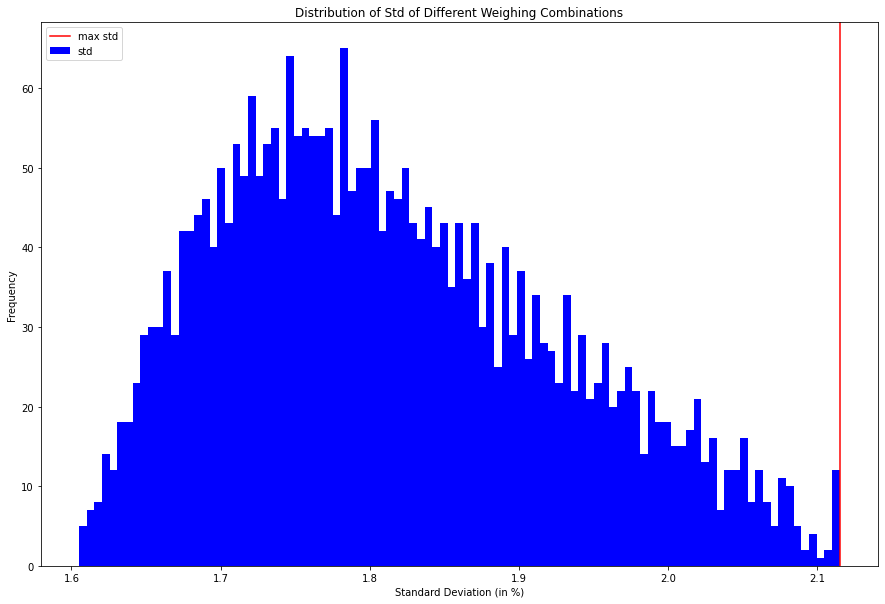

In [22]:
### Use a histogram to show the std of other weightings
# Create the interval classes
bins_max = max(all_std)
bins_min = min(all_std)
bins_intervals = 100
bins = np.linspace(bins_min, bins_max, bins_intervals)

# Create the histogram
plt.rcParams["figure.figsize"] = (15,10)
plt.hist(all_std, bins, color='b', label='std')
plt.axvline(x=max_std, color='r', label='max std')

# Formatting
plt.title("Distribution of Std of Different Weighing Combinations")
plt.xlabel("Standard Deviation (in %)")
plt.ylabel("Frequency")
plt.legend(loc='best')

# Display
plt.show()

### Step 7 Given the chosen portfolio, measure its performance against the price weighted index consisting of all filtered US Stocks in Step 2

### Step 8 Creating the final portfolio with csv

In [23]:
# Access the price on the required date
def price_on_date(ticker, date, next_date):
    return yf.Ticker(ticker).history(start=date, end=next_date)[['Close']].iloc[0,0]

In [24]:
### Create the output as required
final_tickers = max_corr_ticker_lst
final_weights = optimal_weights
investment = 1000000
required_date = '2021-11-11'
next_date = '2021-11-12'

# Get the price, share, value, weight of the ticker on required date
price = []
value = []
share = []
weight = []
for i in range (len(final_tickers)):
    price.append(price_on_date(str(final_tickers[i]), required_date, next_date))
    value.append(investment * final_weights[i])
    share.append(value[i] / price[i])
    weight.append(final_weights[i] * 100)
    

# Create a diction to store the required info
final_dic = {'Ticker' : final_tickers,
             'Price'  : price,
             'Shares' : share,
             'Value'  : value,
             'Weight' : weight}

# Create the final df
FinalPortfolio = pd.DataFrame(final_dic)
# Shift the index
FinalPortfolio.index = np.arange(1, len(FinalPortfolio)+1)

# Display
FinalPortfolio

,Ticker,Price,Shares,Value,Weight
1,OXY,32.119999,10896.637971,350000.0,35.0
2,SLB,32.779999,7626.601870,250000.0,25.0
3,COP,72.139999,693.096762,50000.0,5.0
4,COF,156.549988,319.386802,50000.0,5.0
5,AIG,58.860001,849.473318,50000.0,5.0
6,SPG,165.440002,302.224367,50000.0,5.0
7,AXP,181.300003,275.785985,50000.0,5.0
8,BAC,47.490002,1052.853195,50000.0,5.0
9,USB,60.779999,822.639043,50000.0,5.0
10,BK,59.990002,833.472222,50000.0,5.0


### Step 9 Given the chosen portfolio of 10 stocks, graph the change in portfolio standard deviation as other risky stocks (from the 10 that weren’t chosen in Step 4) are added in

In [ ]:
#To make this process easier, I will simply make a price weighted index and add on stocks as we go along with my own dataframe

#Tickers that are contained in our final portfolio
max_corr_ticker_lst

#For the function below, list_of_stocks is always max_corr_ticker_lst plus another stock chosen from the filtered stocks for volume
# amount_of_monye is always 100000
# start_date is always July 2, 2021
# end_date is always October 22, 2021

#Standard deviaiton arrya that will then be used to graph
SD_array = []

#Loop through for the stocks
def create_portfolio (list_of_stocks, amount_of_money, start_date, end_date):

    yf_stocks = []

    #All the stock data is loaded in us_stock_lst

    #Filter through for the stock data that we need
    for g in range (len (list_of_stocks)):

        for h in range (len (us_stock_lst)): 

            if us_stock_lst[h].info['symbol'] == list_of_stocks[g]:
                yf_stocks.append(us_stock_lst[h].history(start=start_date, end=end_date))
    
    #Calculates number of stocks I need
    money_per_stock = amount_of_money/len(yf_stocks)
    
    #Number of shares
    num_shares = []
    for h in range(len(list_of_stocks)):
        num_shares.append(money_per_stock / yf_stocks[h].Close[0])
    
    #Daily closing price
    closing_prices = []
    for i in range(len(list_of_stocks)):
        closing_prices.append(pd.DataFrame(yf_stocks[i]['Close']))
    
    #Combine the columns to make a dataframe
    prices = pd.concat(closing_prices, join='inner', axis=1)
    
    #Rename the columns
    column_names = []
    for j in range(len(list_of_stocks)):
        column_names.append(list_of_stocks[j][0])
    prices.columns = column_names
    
    #Create the portfolio value
    portfolio_value = 0
    for k in range(len(list_of_stocks)):
        portfolio_value = portfolio_value + num_shares[k]*prices.iloc[:,k]
    
    data = {'Date': prices.index,
            'Portfolio_Value'+str(len(yf_stocks)): portfolio_value}
    
    portfolio_frame = pd.DataFrame(data)
    
    portfolio_dataframe= pd.concat([prices, portfolio_frame], join='inner', axis=1)
    
    #Drop the duplicate column
    portfolio_dataframe.drop(columns=['Date'], inplace=True)

    portfolio_std = portfolio_dataframe.pct_change().std()[len(list_of_stocks)]

    SD_array.append(portfolio_std)
   
    return SD_array 

create_portfolio(max_corr_ticker_lst, 100000, '2021-07-02', '2021-10-22')

In [ ]:
max_corr_ticker_lst

In [ ]:
# Will beging to remove stocks from rest_of_stocks that represent how many stock we have left but first we must filter out the stocks 
# that are in max_corr_lst
rest_of_stocks = filtered_stocks

#Filter out the stocks already in max_corr_lst. Now it is only stocks that I am interested in
for y in range (len(max_corr_ticker_lst)):

    for u in range (len (rest_of_stocks)-1):
        
        if (max_corr_ticker_lst[y] == rest_of_stocks[u].info['symbol']):
            rest_of_stocks.pop(u)

# Need to make another function that loops through the valid stocks and calcualtes the standrad deviation that is then appended to 
# a standrad deviation array.
#Only thing that changes from thing to thing is the number of stocks that are used.

In [ ]:
max_corr_ticker_lst

In [ ]:
rest_of_stocks

In [ ]:
#Stocks that are currently being processed (will be appended to as more are added on)
max_corr_ticker_lst

for w in range(len(rest_of_stocks)):
    max_corr_ticker_lst.append(rest_of_stocks[w].info['symbol'])

    create_portfolio(max_corr_ticker_lst, 100000, '2021-07-02', '2021-10-22') 

nums = []
for k in range (45):
    nums.append(k+1)

In [ ]:
len(stocks_at_the_moment)

In [ ]:
#Graphing portion
#graph out the standard deviation
plt.figure(figsize=(20,15))

plt.plot(nums, SD_array, color='b', label='Standard Deviation')
plt.legend(loc='best')
plt.title('Standard Deviation of the Percentage Return as more stocks are added')
plt.xlabel('Number of Industries')
plt.ylabel('Standard Deviation')

## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Insert Names Here. 